.. index::
   pair: Methods; Discontinuous Galerkin

# Discontinuous Galerkin Methods

## Advection-Diffusion: Discontinuous Galerkin Method with Upwinding
.. index:: Equations; Advection-Diffusion

.. index::
   pair: Spaces; DG Legendre

So far we have been using Lagrange spaces of different order to solve our
PDE. In the following we show how to use Discontinuous Galerkin method to
solve an advection dominated advection-diffusion problem:
\begin{align*}
-\varepsilon\triangle u + b\cdot\nabla u &= f
\end{align*}
with Dirichlet boundary conditions. Here $\varepsilon$ is a small
constant and $b$ a given vector.

In [1]:
import numpy, math, sys
from matplotlib import pyplot
from dune.grid import cartesianDomain
# from dune.alugrid import aluConformGrid as leafGridView
# from dune.fem.space import dgonb as dgSpace
from dune.grid import yaspGrid as leafGridView
from dune.fem.space import dglegendre as dgSpace
from dune.fem.scheme import galerkin as solutionScheme
from dune.ufl import Constant
from ufl import ( TestFunction, TrialFunction, SpatialCoordinate, FacetNormal,
                  dx, ds, grad, div, grad, dot, inner, sqrt, exp, atan, conditional,
                  as_vector, avg, jump, dS, CellVolume, FacetArea )

# overlap=1 is needed for parallel computations
domain   = cartesianDomain([-1, -1], [1, 1], [20, 20], overlap=1)
gridView = leafGridView(domain)
space    = dgSpace(gridView, order=2)


# check if computation is parallel
parallel = gridView.comm.size > 1


.. todo:: add some more details on the forms for upwinding


In [2]:
u    = TrialFunction(space)
v    = TestFunction(space)
n    = FacetNormal(space)
he   = avg( CellVolume(space) ) / FacetArea(space)
hbnd = CellVolume(space) / FacetArea(space)
x    = SpatialCoordinate(space)

# diffusion factor
eps = Constant(0.1,"eps")
# transport direction and upwind flux
b    = as_vector([1,0])
hatb = (dot(b, n) + abs(dot(b, n)))/2.0
# boundary values (for left/right boundary)
dD   = conditional((1+x[0])*(1-x[0])<1e-10,1,0)
g    = conditional(x[0]<0,atan(10*x[1]),0)
# penalty parameter (take 1 for p=0)
beta = 10 * space.order**2 if space.order > 0 else 1

                # eps*dot(avg(grad(u)),n('+'))*jump(v)*dS -
                # eps*jump(u)*dot(avg(grad(v)),n('+'))*dS
dn = lambda u: dot(grad(u),n)
aInternal     = dot(eps*grad(u) - b*u, grad(v)) * dx
diffSkeleton  = eps*beta/he*jump(u)*jump(v)*dS -\
                eps*avg(dn(u))*jump(v)*dS -\
                eps*jump(u)*avg(dn(v))*dS
diffSkeleton += eps*beta/hbnd*(u-g)*v*dD*ds -\
                eps*dot(grad(u),n)*v*dD*ds
advSkeleton   = jump(hatb*u)*jump(v)*dS
advSkeleton  += ( hatb*u + (dot(b,n)-hatb)*g )*v*dD*ds
form          = aInternal + diffSkeleton + advSkeleton

We solve the problem as in previous examples

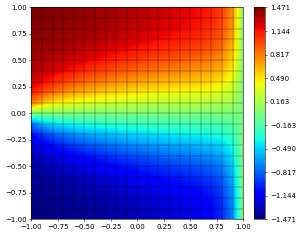

In [3]:
scheme = solutionScheme(form==0, solver="gmres",
            parameters={"linear.preconditioning.method":"jacobi",
                       # "nonlinear.verbose": True,
                       }
                        )
uh = space.interpolate(0, name="solution")
info = scheme.solve(target=uh)

if parallel:
    gridView.writeVTK("u_h", pointdata=[uh])
else:
    uh.plot()

So far the example was not really advection dominated so we now
repeat the experiment but set $\varepsilon=1e-5$

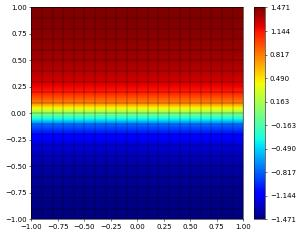

In [4]:
eps.value = 1e-5 # could also use scheme.model.eps = 1e-5
uh.interpolate(0)
scheme.solve(target=uh)

if parallel:
    gridView.writeVTK("u_h", pointdata=[uh])
else:
    uh.plot()

# for parallel runs skip 1d part
if parallel:
    sys.exit(0)

## A linear transport problem
.. index:: Equations; Transport

.. index:: Spaces; DG Legendre

.. index:: Methods; Method of Lines

We now use a DG space to approximate the solution to the transport problem
$$ \partial_t u + b\cdot \nabla u = f $$

with a constant transport velocity vector $b$. We will solve the problem
in one space dimension taking $b=\frac{1}{2}$.


We first setup the 1D grid and the Discontinuous Galerkin space.

In [5]:
# remove later, shows same error: from dune.fem.space import dgonb as dgSpace
N = 200
domain1d = cartesianDomain([0], [1], [N], overlap=1)
gridView = leafGridView( domain1d )
space    = dgSpace(gridView, order=1)

The space discretization uses the same upwind flux discussed already for the
Advection-Diffusion problem in a previous example. This can be written as
an ODE
$$ \int_\Omega \partial_t u(t)\varphi_i = F_i(u(t)) $$

where $(\varphi_i)_i$ is a basis of a DG space, i.e.,
$\varphi_i=\varphi^E_l$ only has support on one element $E$ of the grid.
This leads to the matrix vector problem
$$ M\frac{d}{dt} \vec{u}(t) = \vec{F}(\vec{u}(t)) $$

where $M$ is the mass matrix which in the case of a DG space is block
diagonal - in fact with the `dune.fem.space.dglegendre` space the mass
matrix is even diagonal. The ODE is thus of the form
$$ \frac{d}{dt} \vec{u}(t) = M^{-1}\vec{F}(\vec{u}(t)) $$

We discretize this ODE using an explicit two-step Runge-Kutta method with
a fixed time-step $\tau$. Given $\vec{u}^n$ we define the solution at the
next time step by
$$ \vec{u}^{n+1} := \frac{1}{2}\Big(\vec{u}_1^{n+1} + \vec{u}_2^{n+1} \Big) $$

with
\begin{align*}
\vec{u}_1^{n+1} &= \vec{u}^n   + \tau M^{-1}\vec{F}(\vec{u}^n) \\
\vec{u}_2^{n+1} &= \vec{u}_1^n + \tau M^{-1}\vec{F}(\vec{u}_1^n)
\end{align*}
This is __Heun's method__.

We first setup the form for the right hand side $\vec{F}$ which is very
similar to the stationary case described above:

In [6]:
u    = TrialFunction(space)
v    = TestFunction(space)
n    = FacetNormal(space)
x    = SpatialCoordinate(space)

# transport direction and upwind flux
speed = 0.5
b     = as_vector([speed])
hatb  = (dot(b, n) + abs(dot(b, n)))/2.0
# boundary values (for left boundary)
dD    = conditional(x[0]<0.01,1,0)
g     = 1

# forms
advInternal = dot(-b*u, grad(v)) * dx
advSkeleton = jump(hatb*u)*jump(v) * dS
advBnd      = ( hatb*u + (dot(b,n)-hatb)*g )*v * dD*ds
form        = (advInternal + advSkeleton + advBnd)

We could use the standard approach based on the `dune.fem.operator.galerkin` construction
but this requires adding the inverse mass operator later on. `dune-fem` provide an alternative approach
where the operator automatically includes the inverse mass matrix:

In [7]:
from dune.fem.operator import molGalerkin as molOperator
op = molOperator(form)

So `op(uh,res)` applies the given operator to `uh`,
applies the inverse mass matrix and stores the result in `res`.
Consequently in our case, `op(uh,res)` computes
$M^{-1}\vec{F}(\vec{u}^n)$ as required.

The remaining code is a rather standard time loop where we compute for a
given old time step vector $\vec{u}$ the new vector
$$ \frac{1}{2}\Big( \vec{u}_1^{n+1} + \vec{u}_2^{n+1} \Big) $$

by applying the above operator twice.

We show the transport of a a simple discontinuety:

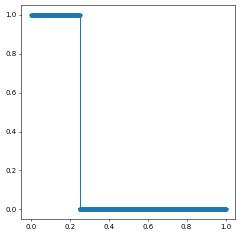

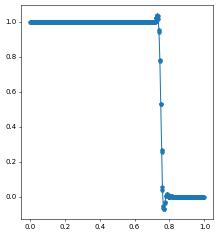

In [8]:
uh = space.interpolate(conditional(x[0]<0.25,1,0), name="solution")
uh.plot()
w = uh.copy()
un = uh.copy()
cfl = 0.1
tau = cfl/(speed*N)

t = 0
while t<1:
    un.assign(uh)

    op(uh, w)
    uh.axpy(-tau,w)   # with numpy backend equivalent to 'uh.as_numpy[:] -= tau*w.as_numpy[:]'
    op(uh, w)
    uh.axpy(-tau,w)   # with numpy backend equivalent to 'uh.as_numpy[:] -= tau*w.as_numpy[:]'

    # with numpy backend the following is equivalent to
    # 'uh.as_numpy[:] = 0.5*(uh.as_numpy[:] + un.as_numpy[:])'
    uh *= 0.5
    uh.axpy(0.5,un)
    t += tau
uh.plot()


.. todo:: add some remarks on spectral dg

The `dune.femdg` module provides further methods for solving time
dependent advection-diffusion problem. The module includes
implicit-explicit Runge-Kutta methods and stabilization approaches for
non-linear advection dominated models. This module is described in
more details in [other places in this tutorial](furtherexamples.rst#Discontinuous-Galerkin-Methods-with-DUNE-FEM-DG).